In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# normalize_img normalizes our output to be between 0 and 1
def normalize_img(im):
    img = im.copy()
    img += np.abs(np.min(img))
    img /= np.max(img)
    return img

In [3]:
def l2_top_bottom(patch_top, patch_bottom):
    block_top  = patch_top[-overlap_size:, :]
    
    if patch_bottom.ndim == 3:
        block_bottom = patch_bottom[:overlap_size]
    elif patch_bottom.ndim == 4:
        block_bottom = patch_bottom[:, :overlap_size]
        
    top_cost  = l2_loss(block_top, block_bottom)
    
    return top_cost

def l2_left_right(patch_left, patch_right):
    block_left  = patch_left[:, -overlap_size:]
    
    if patch_right.ndim == 3:
        block_right = patch_right[:, :overlap_size]
    elif patch_right.ndim == 4:
        block_right = patch_right[:, :, :overlap_size]

    left_cost  = l2_loss(block_left, block_right)
    
    return left_cost

In [4]:
def l2_loss(block_1, block_2):
    sqdfs = np.sum((block_1 - block_2) ** 2, axis=-1)
    return np.sqrt(np.sum(np.sum(sqdfs, axis=-1), axis=-1))

In [5]:
def select_min_patch(patches, cost):
    min_cost  = np.min(cost)
    tolerance = 0.1
    upper_cost_bound = min_cost + tolerance * min_cost
    # pick random patch within tolerance
    patch = patches[np.random.choice(np.argwhere(cost <= upper_cost_bound).flatten())]
    return patch

In [6]:
def compute_error_surface(block_1, block_2):
    return np.sum((block_1 - block_2) ** 2, axis=-1)

In [7]:

def min_vert_path(error_surf_vert):
    top_min_path = np.zeros((block_size), dtype=np.int)
    top_min_path[0] = np.argmin(error_surf_vert[0, :], axis=0)
    for i in range(1, block_size):
        err_mid_v = error_surf_vert[i, :]
        mid_v = err_mid_v[top_min_path[i - 1]]

        err_left = np.roll(error_surf_vert[i, :], 1, axis=0)
        err_left[0] = np.inf
        left = err_left[top_min_path[i - 1]]

        err_right = np.roll(error_surf_vert[i, :], -1, axis=0)
        err_right[-1] = np.inf
        right = err_right[top_min_path[i - 1]]

        next_poss_pts_v = np.vstack((left, mid_v, right))
        new_pts_ind_v = top_min_path[i - 1] + (np.argmin(next_poss_pts_v, axis=0) - 1)
        top_min_path[i] = new_pts_ind_v

    return top_min_path

def min_hor_path(error_surf_hor):
    left_min_path = np.zeros((block_size), dtype=np.int)
    left_min_path[0] = np.argmin(error_surf_hor[:, 0], axis=0)
    for i in range(1, block_size):
        err_mid_h = error_surf_hor[:, i]
        mid_h = err_mid_h[left_min_path[i - 1]]

        err_top = np.roll(error_surf_hor[:, i], 1, axis=0)
        err_top[0] = np.inf
        top = err_top[left_min_path[i - 1]]

        err_bot = np.roll(error_surf_hor[:, i], -1, axis=0)
        err_bot[-1] = np.inf
        bot = err_bot[left_min_path[i - 1]]

        next_poss_pts_h = np.vstack((top, mid_h, bot))
        new_pts_ind_h = left_min_path[i - 1] + (np.argmin(next_poss_pts_h, axis=0) - 1)
        left_min_path[i] = new_pts_ind_h
        
    return left_min_path

In [8]:
def compute_lr_join(block_left, block_right, error_surf_vert=None):
    if error_surf_vert is None:
        error_surf_vert = compute_error_surface(block_right, block_left)
    
    vert_path = min_vert_path(error_surf_vert)
    yy, xx = np.meshgrid(np.arange(block_size), np.arange(overlap_size))
    vert_mask = xx.T <= np.tile(np.expand_dims(vert_path, 1), overlap_size)
    
    lr_join = np.zeros_like(block_left)
    lr_join[:, :][vert_mask]  = block_left[vert_mask]
    lr_join[:, :][~vert_mask] = block_right[~vert_mask]
    
    return lr_join

def compute_bt_join(block_top, block_bottom, error_surf_hor=None):
    if error_surf_hor is None:
        error_surf_hor = compute_error_surface(block_bottom, block_top)

    hor_path = min_hor_path(error_surf_hor)
    yy, xx = np.meshgrid(np.arange(block_size), np.arange(overlap_size))
    hor_mask = (xx.T <= np.tile(np.expand_dims(hor_path, 1), overlap_size)).T
    
    bt_join = np.zeros_like(block_top)
    bt_join[:, :][hor_mask] = block_top[hor_mask]
    bt_join[:, :][~hor_mask] = block_bottom[~hor_mask]

    return bt_join

In [9]:
def lr_bt_join_double(best_left_block, right_block, best_top_block, bottom_block):
    error_surf_hor  = compute_error_surface(best_left_block, right_block)
    error_surf_vert = compute_error_surface(best_top_block, bottom_block)

    vert_contrib = np.zeros_like(error_surf_vert)
    hor_contrib  = np.zeros_like(error_surf_hor)

    vert_contrib[:, :overlap_size] += (error_surf_hor[:overlap_size, :] + error_surf_vert[:, :overlap_size])/2
    hor_contrib[:overlap_size, :]  += (error_surf_vert[:, :overlap_size] + error_surf_hor[:overlap_size, :])/2

    error_surf_vert += vert_contrib
    error_surf_hor  += hor_contrib

    left_right_join = compute_lr_join(right_block, best_left_block, error_surf_vert=error_surf_hor)
    bottom_top_join = compute_bt_join(bottom_block, best_top_block, error_surf_hor=error_surf_vert)
    
    return left_right_join, bottom_top_join

In [10]:
def synth_texture(src_texture, block_size):
    h, w, c = src_texture.shape
    
    assert block_size < min(h, w)
    
    y_max, x_max = h - block_size, w - block_size
    dh = h * 2
    dw = w * 2
    nx_blocks = ny_blocks = max(dh, dw) // block_size
    w_new = h_new = nx_blocks * block_size - (nx_blocks - 1) * overlap_size
    n_blocks = nx_blocks * ny_blocks
    xs = np.arange(x_max)
    ys = np.arange(y_max)
    all_blocks = np.array([src_texture[y:y + block_size, x:x + block_size] for x in xs for y in ys])
    
    
    target_height = h_new
    target_width = w_new
    target = np.zeros((target_height, target_width, c), dtype=texture_1.dtype)

    step = block_size - overlap_size

    y_begin = 0
    y_end = block_size

    for y in range(ny_blocks):

        x_begin = 0
        x_end = block_size

        for x in range(nx_blocks):
            if x == 0 and y == 0:
                # randomly select top left patch
                r = np.random.randint(len(all_blocks))
                random_patch = all_blocks[r]
                target[y_begin:y_end, x_begin:x_end] = random_patch

                x_begin = x_end
                x_end  += step

                continue

            xa, xb = x_begin - block_size, x_begin
            ya, yb = y_begin - block_size, y_begin

            if y == 0:
                y1 = 0
                y2 = block_size

                left_patch = target[y1:y2, xa:xb]
                left_block = left_patch[:, -overlap_size:]
                left_cost  = l2_left_right(patch_left=left_patch, patch_right=all_blocks)
                best_right_patch = select_min_patch(all_blocks, left_cost)
                best_right_block = best_right_patch[:, :overlap_size]

                left_right_join = compute_lr_join(left_block, best_right_block)
                # join left and right blocks
                full_join = np.hstack((target[y1:y2, xa:xb-overlap_size], left_right_join, best_right_patch[:, overlap_size:]))

                target[y1:y2, xa:x_end] = full_join
            else:
                if x == 0:
                    x1 = 0
                    x2 = block_size
                    top_patch = target[ya:yb, x1:x2]
                    top_block = top_patch[-overlap_size:, :]
                    top_cost = l2_top_bottom(patch_top=top_patch, patch_bottom=all_blocks)
                    best_bottom_patch = select_min_patch(all_blocks, top_cost)
                    best_bottom_block = best_bottom_patch[:overlap_size, :]

                    # join top and bottom blocks
                    top_bottom_join = compute_bt_join(top_block, best_bottom_block)
                    full_join = np.vstack((target[ya:yb-overlap_size, x1:x2], top_bottom_join, best_bottom_patch[overlap_size:, :]))

                    target[ya:y_end, x1:x2] = full_join
                else:
                    # overlap is L-shaped
                    y1, y2 = y_begin - overlap_size, y_end
                    x1, x2 = x_begin - overlap_size, x_end

                    left_patch = target[y1:y2, xa:xb]
                    top_patch = target[ya:yb, x1:x2]

                    left_block = left_patch[:, -overlap_size:]
                    top_block = top_patch[-overlap_size:, :]

                    left_cost  = l2_left_right(patch_left=left_patch, patch_right=all_blocks)
                    top_cost = l2_top_bottom(patch_top=top_patch, patch_bottom=all_blocks)

                    best_right_patch = best_bottom_patch = select_min_patch(all_blocks, top_cost + left_cost)

                    best_right_block = best_right_patch[:, :overlap_size]
                    best_bottom_block = best_bottom_patch[:overlap_size, :]

                    left_right_join, top_bottom_join = lr_bt_join_double(best_right_block, left_block, best_bottom_block, top_block)
                    # join left and right blocks
                    full_lr_join = np.hstack((target[y1:y2, xa:xb-overlap_size], left_right_join, best_right_patch[:, overlap_size:]))

                    # join top and bottom blocks
                    full_tb_join = np.vstack((target[ya:yb-overlap_size, x1:x2], top_bottom_join, best_bottom_patch[overlap_size:, :]))

                    target[ya:y_end, x1:x2] = full_tb_join
                    target[y1:y2, xa:x_end] = full_lr_join

            x_begin = x_end
            x_end  += step

        y_begin = y_end
        y_end  += step
        
    return target

C:\Users\Medha Tiwari\AppData\Local\Temp\ipykernel_148676\347157121.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  top_min_path = np.zeros((block_size), dtype=np.int)
C:\Users\Medha Tiwari\AppData\Local\Temp\ipykernel_148676\347157121.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curr

Time elapsed = 33.63s


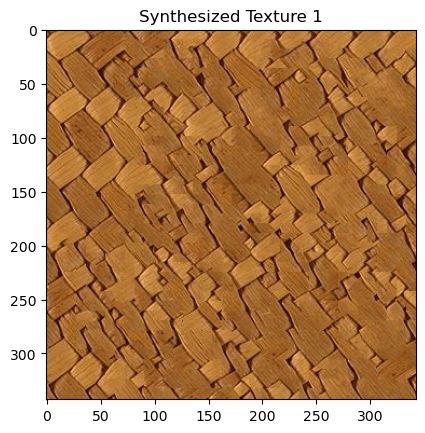

In [15]:
texture_1 = plt.imread('texture2.jpg').astype(np.float32)
block_size = 10
overlap_size = int(block_size / 6)

t0 = time.time()
synthesized_texture = synth_texture(texture_1, block_size)
t1 = time.time()

print('Time elapsed = %.2fs' % (t1 - t0))

plt.title('Synthesized Texture %d' % 1)
plt.imshow(normalize_img(synthesized_texture))
plt.show()

In [12]:
plt.imsave('synthesis_result.jpg', normalize_img(synthesized_texture))

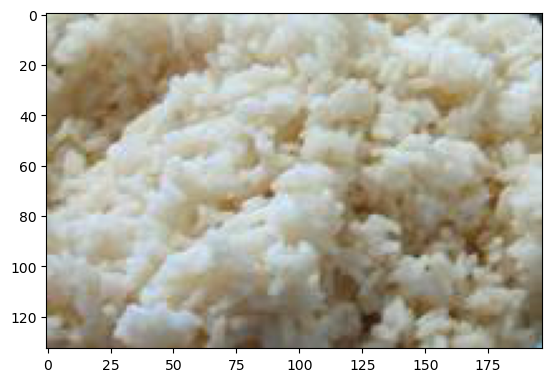

In [13]:
plt.imshow(normalize_img(texture_1))